In [1]:
%load_ext autoreload
%autoreload 2

# Compare the same dataset with different starting counts

We want to see if the peak in circuits with a certain (small) senitivity value is due to the initial copy numbers. For this, we simulated two datasets with the same circuit topologies / binding energies as dataset `2024_11_27_145142`, but with two different starting copy numbers.

Dataset `2026_01_12__18_50_13` has a starting copynumber of 100, while dataset `2026_01_14__22_38_47` has a starting count of 200 (which is the same as dataset `2024_11_27_145142`, but we needed to resimulate this to make sure any changes to the underlying code for simulation are accounted for). 

In this notebook, we compare the two simulated datasets and find that their sensitivity distributions do not differ substantially and they have the same sensitivity peak.

In [2]:
import numpy as np
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from common import set_theme

PALETTE = 'viridis'
set_theme()

top_write_dir = os.path.join('data', '27_sensitivity_peak3')

Load all the data
- original dataset
- resimulation of dataset with starting copynumber = 100
- resimulation of dataset with starting copynumber = 200

In [3]:
fn_og = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
fn1 = 'data/simulate_circuits/2026_01_12__18_50_13/analytics.json'
fn2 = 'data/simulate_circuits/2026_01_14__22_38_47/analytics.json'
df_og = pd.read_csv(fn_og)
df1 = pd.read_json(fn1)
df2 = pd.read_json(fn2)
df1 = df1.explode(df1.columns.to_list()).reset_index(drop=True)
df2 = df2.explode(df2.columns.to_list()).reset_index(drop=True)


Process analytics into dataframes that match the dataframe of the original dataset

In [4]:
names_species_input = df_og['sample_name'].unique()
n_species_input = len(names_species_input)
n_species_total = int(len(df1) / len(df_og) * n_species_input)
df1['sample_name'] = (np.arange(n_species_total) * np.ones((int(len(df1)/n_species_total), n_species_total))).flatten()
df1 = df1[df1['sample_name'].isin(list(np.arange(n_species_total)[-n_species_input:]))].reset_index(drop=True)
df2['sample_name'] = (np.arange(n_species_total) * np.ones((int(len(df2)/n_species_total), n_species_total))).flatten()
df2 = df2[df2['sample_name'].isin(list(np.arange(n_species_total)[-n_species_input:]))].reset_index(drop=True)
df1['sample_name'] = df1['sample_name'].map(lambda x: names_species_input[int(x - (n_species_total - n_species_input))])
df2['sample_name'] = df2['sample_name'].map(lambda x: names_species_input[int(x - (n_species_total - n_species_input))])
len(df1), len(df2)


(2535000, 2535000)

Copy identity columns from original dataset to the resimulated datasets

In [5]:
cols_to_add = ['circuit_name', 'mutation_name', 'mutation_num']
df1[cols_to_add] = df_og[cols_to_add]
df2[cols_to_add] = df_og[cols_to_add]

# Visualise

Text(0.5, 1.0, 'The sensitivity peak is not due to the starting copynumber')

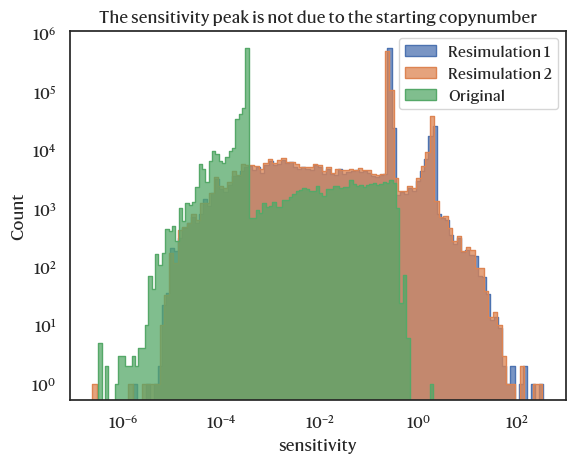

In [6]:
filt = lambda d: d[d['sample_name'] == 'RNA_2']
sns.histplot(filt(df1), x='sensitivity', bins=100, log_scale=(True, False), element='step')
sns.histplot(filt(df2), x='sensitivity', bins=100, log_scale=(True, False), element='step')
sns.histplot(filt(df_og), x='sensitivity', bins=100, log_scale=(True, False), element='step')
plt.yscale('log')
plt.legend(['Resimulation 1', 'Resimulation 2', 'Original'])
plt.title('The sensitivity peak is not due to the starting copynumber')

/tmp/ipykernel_400335/973993188.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(filt(d), x='sensitivity', y='precision', palette=PALETTE, ax=axs[i], alpha=0.1)
/tmp/ipykernel_400335/973993188.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(filt(d), x='sensitivity', y='precision', palette=PALETTE, ax=axs[i], alpha=0.1)
/tmp/ipykernel_400335/973993188.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(filt(d), x='sensitivity', y='precision', palette=PALETTE, ax=axs[i], alpha=0.1)


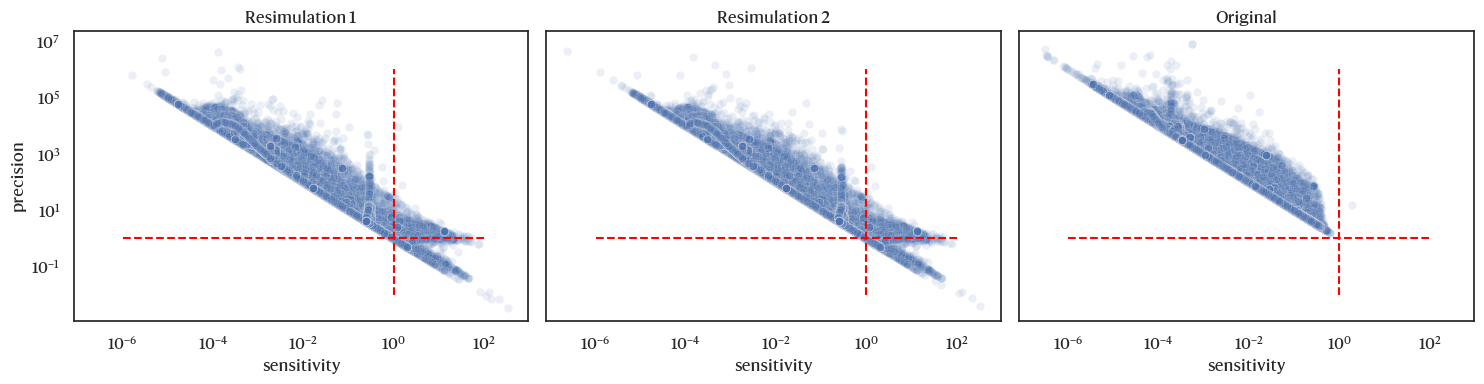

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
for i, (d, title) in enumerate(zip([df1, df2, df_og], ['Resimulation 1', 'Resimulation 2', 'Original'])):
    sns.scatterplot(filt(d), x='sensitivity', y='precision', palette=PALETTE, ax=axs[i], alpha=0.1)
    axs[i].vlines(x=1, ymin=1e-2, ymax=1e6, colors='red', linestyles='dashed')
    axs[i].hlines(y=1, xmin=1e-6, xmax=1e2, colors='red', linestyles='dashed')
    axs[i].set_title(title)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
plt.tight_layout()

# Check configs for other simulation settings

In [8]:
cfg1 = os.path.join(os.path.dirname(fn1), 'config.json')
with open(cfg1, 'r') as f:
    config1 = json.load(f)
cfg2 = os.path.join(os.path.dirname(fn2), 'config.json')
with open(cfg2, 'r') as f:
    config2 = json.load(f)
cfg_og = os.path.join(os.path.dirname(fn_og), 'ensemble_config.json')
with open(cfg_og, 'r') as f:
    config_og = json.load(f)['base_configs_ensemble']['mutation_effect_on_interactions_signal']

Config 1 and 2 for simulation setting are the same, since we only changed the starting copynumbers. Therefore, we can compare the configuration of either one to that of the original dataset to see why the peak shifted.

In [9]:
config1['simulation'] == config2['simulation']

True

In [10]:
for k, v in config1['simulation'].items():
    if config_og['simulation'].get(k) != v:
        print(f'Key: {k}')
        print(f'Old: {config_og["simulation"].get(k)}')
        print(f'New: {v}')
        print('---')

Key: dt0
Old: 0.01
New: 0.0001
---
Key: t1
Old: 500
New: 1000
---
Key: tmax
Old: 2000
New: 8000
---
Key: threshold_steady_states
Old: 0.05
New: 0.02
---
Key: save_steps
Old: None
New: 100
---
Key: save_steps_uselog
Old: None
New: True
---


# How do simulation settings determine peak?

The `dt0` likely does not affect steady state as much as a larger `tmax` and (most crucially) the `threshold_steady_states`. 


## Threshold calculations

Let's work out if the threshold for determining if something is at steady state is responsible.

A threshold of 0.01 means that a circuit's trace is determined to be "at steady state" if the estimate of the first derivative (calculated as the `jax` gradient of the final 3 points in `src/evoscaper/utils/simulation.py`) normalised by the final `y` value has to be below the threshold:

steady state $= \frac{y'}{y_{\text{final}}} < \text{threshold}$

This has to be true for all circuits in the batch being simulated, or the batch continues for another mini-simulation round until a steady state is found.

The `dt` at the time of this simulation point affects the value of `y'`. Unfortunately, we did not normalise by the time interval, but only the final `y`. This does mean that circuits with very slow reaction times may get simulated incorrectly, with simulations stopping earlier than a slow circuit actually reaches steady state, since the thresholding cannot differentiate between slow-moving and fast-moving circuits. However, this is not relevant for the simulations, as we cut off the solver before such slow circuits would have a chance to steady out anyway. These circuits then tend to have undefined response times and are left out of the subsequent simulation pipeline.

Let's only consider the peak circuits, which tend to have a binding energy of 0 for all signal-species interactions, and in most cases 0 for all interactions.

In [11]:
initial_steady_states_resim = df2[df2['sample_name'] == 'RNA_2']['initial_steady_states'].value_counts().index[0]
steady_states_resim = df2[df2['sample_name'] == 'RNA_2']['steady_states'].value_counts().index[0]
initial_steady_states_og = df_og[df_og['sample_name'] == 'RNA_2']['initial_steady_states'].value_counts().index[0]
steady_states_og = df_og[df_og['sample_name'] == 'RNA_2']['steady_states'].value_counts().index[0]
initial_steady_states_sig_resim = df2[df2['sample_name'] == 'RNA_0']['initial_steady_states'].value_counts().index[0]
steady_states_sig_resim = df2[df2['sample_name'] == 'RNA_0']['steady_states'].value_counts().index[0]
initial_steady_states_sig_og = df_og[df_og['sample_name'] == 'RNA_0']['initial_steady_states'].value_counts().index[0]
steady_states_sig_og = df_og[df_og['sample_name'] == 'RNA_0']['steady_states'].value_counts().index[0]

[steady_states_resim - initial_steady_states_resim, steady_states_og - initial_steady_states_og,
 steady_states_sig_resim - initial_steady_states_sig_resim, steady_states_sig_og - initial_steady_states_sig_og]

[-0.0665283203125,
 np.float64(-0.0665700000000129),
 -0.533447265625,
 np.float64(199.19892000000002)]

Since binding energy is zero, the equilibrium constant $K_{eq}$ has to be equal to 1, since neither the association rate `k_a` or the dissociation rate `k_d` are dominating the reaction. However, we are not using the Gibbs free energy equation to calculate the equilibrium constant from the minimum free binding energy $\Delta$ G - we are using a reparameterised equation that heavily skews the $K_{eq}$ based on real data, so that a binding energy of zero essentially means no binding.

In [12]:
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
cols_e = get_true_interaction_cols(df_og, 'energies', remove_symmetrical=True)
cols_r = get_true_interaction_cols(df_og, 'binding_rates_dissociation', remove_symmetrical=True)

# df_og['Is at peak'] = df_og['initial_steady_states'] == initial_steady_states_og
k_d = df_og[df_og['initial_steady_states'] == initial_steady_states_og][cols_r[0]].iloc[0]


In [13]:
from synbio_morpher.utils.modelling.physical import gibbs_K, equilibrium_constant_reparameterisation

eqconstant = equilibrium_constant_reparameterisation(0, initial=200)
k_a = k_d * np.array(eqconstant)

gibbs_K(0), equilibrium_constant_reparameterisation(0, initial=200), equilibrium_constant_reparameterisation(0, initial=1)

(Array(1., dtype=float32),
 Array(1.6773131e-06, dtype=float32, weak_type=True),
 Array(0.00033546, dtype=float32, weak_type=True))

Here is the equation governing the change in RNA_0 (or x_0 here) given our 3-node RNA system:

$\frac{dx_0}{dt} = - 2 * k_{a00} * x_0^2 - k_{a01} * x_0 * x_1 - k_{a02} * x_0 * x_2 $
$+ 2 * k_{d00} * x_{00} + k_{d01} * x_{01} + k_{d02} * x_{02}$

How does the above change if k_a is the same for all species? Same for k_d?

$\frac{dx_0}{dt} = - k_a * x_0 (2 * x_0 + x_1 + x_2) + k_d (2 * x_{00} + x_{01} + x{02})$

If x_0 = x_1 = x_2 at the beginning and same for the paired forms, how does that change things?

$\frac{dx}{dt} = k_a * (n+1) * x^2 - k_d * (n_p+1) * x_{paired}$

where $n$ is the number of input species and $n_p$ is the number of paired species related to the current species. Once we add the signal, this no longer holds true. We can set this up to be more general by defining a matrix describing the number of each species in each reaction, of which there are 6 unique reactions.

$RNA_1 + RNA_1 → RNA_{11}$

$RNA_1 + RNA_2 → RNA_{12}$

$RNA_1 + RNA_3 → RNA_{13}$

$RNA_2 + RNA_2 → RNA_{22}$

$RNA_2 + RNA_3 → RNA_{23}$

$RNA_3 + RNA_3 → RNA_{33}$



In [14]:
n = n_species_input
n_p = n_species_input

k_d, k_a, eqconstant, initial_steady_states_resim, steady_states_resim, initial_steady_states_sig_resim, steady_states_sig_resim

(np.float64(899.9996),
 np.float64(0.0015095811134505312),
 Array(1.6773131e-06, dtype=float32, weak_type=True),
 199.73231506347656,
 199.66578674316406,
 399.4646301269531,
 398.9311828613281)

## Let's simulate this briefly to confirm the numerical simulation result

In [24]:
c_0 = np.float64(config1['molecular_params']['starting_copynumbers'])
eqconstant = equilibrium_constant_reparameterisation(0, initial=c_0)
k_a = k_d * np.array(eqconstant)

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 0, 0, 0], 
    [1, 0, 1, 0, 0, 0, 0, 0, 0], 
    [0, 2, 0, 0, 0, 0, 0, 0, 0], 
    [0, 1, 1, 0, 0, 0, 0, 0, 0], 
    [0, 0, 2, 0, 0, 0, 0, 0, 0], 
])
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 1, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 1, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 1, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 1], 
])
x00 = np.array([c_0, c_0, c_0, 0, 0, 0, 0, 0, 0])

def one_step_de_sim(spec_conc, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = np.prod(
        np.power(spec_conc, inputs), axis=1)
    concentration_factors_out = np.prod(
        np.power(spec_conc, outputs), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


In [36]:
dt = 0.0001
ts0 = np.arange(0, 1, dt)
ts1 = np.arange(0, 1, dt) + max(ts0)
x = np.zeros((len(ts0) + len(ts1), n_species_total))
x[0] = x00
for i in range(len(ts0)):
    if i==0: continue
    dx = one_step_de_sim(
        x[i-1], inputs, outputs,
        k_a, k_d
    ) * dt
    x[i] = x[i-1] + dx
x[len(ts0)] = x[len(ts0)-1]
x[len(ts0), 0] = x[len(ts0)-1, 0] + x[len(ts0)-1, 0]
print(f'Added {x[len(ts0)-1, 0]} to the signal {x[len(ts0)-1, 0]} = {x[len(ts0)-1, 0] + x[len(ts0)-1, 0]}')
for i, ti in enumerate(range(len(ts0), len(ts0) + len(ts1))):
    if i==0: continue
    dx = one_step_de_sim(
        x[ti-1], inputs, outputs,
        k_a, k_d
    ) * dt
    x[ti] = x[ti-1] + dx
print('Starting concentrations:', x00)
print('Initial steady states:', x[len(ts0)-1, :n_species_input])
print('Final steady states:', x[ti, :n_species_input])

Added 99.86617386151711 to the signal 99.86617386151711 = 199.73234772303422
Starting concentrations: [100. 100. 100.   0.   0.   0.   0.   0.   0.]
Initial steady states: [99.86617386 99.86617386 99.86617386]
Final steady states: [199.46563303  99.83289583  99.83289583]


array([100.        ,  99.98792335,  99.97693652, ..., 199.46541039,
       199.46541039, 199.46541039], shape=(20000,))

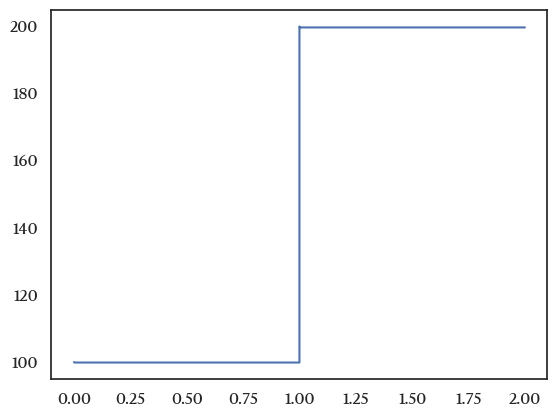

In [26]:
plt.plot(np.concatenate([ts0, ts1]), x[:, 0])
x[:, 0]


# Analytical solution with symmetrical system

The equilibrium constant can relate the concentrations of reactants to their product in the following way:

$[RNA_{ij}] = \frac{k_a}{k_d} [RNA_i][RNA_j]$

We also know that the total amount of a single RNA has to be conserved in the system. If all RNAs start out with the initial copy number or concentration of $c_0 = 100$, then all the individual RNAs and their paired forms have to sum to $c_0$ for a given RNA:

$x_1 + 2 y_{11} + y_{12} + y_{13} = c_0$

Using the equilibrium equation, we can substitute in for each of the paired species as long as the system is symmetrical and $x_1 = x_2 = x_3 = c_0$ initially. We can then use the equilibrium constant directly as $K_{eq} = \frac{k_a}{k_d}$, which we can calculate from our re-parameterisation curve fitted to real RNA binding data.


In [27]:
eqconstant = equilibrium_constant_reparameterisation(0, initial=c_0)
K = np.float64(eqconstant)
k_a = np.float64(k_d) * np.array(K)
print('c_0 =', c_0, '\nK =', K, '\nk_a =', k_a, '\nk_d =', k_d)

c_0 = 100.0 
K = 3.354626187501708e-06 
k_a = 0.0030191622269010623 
k_d = 899.9996


Plugging in the numbers from above as $c_0 = x = 100$ and $K_{eq} = 3.35*10^{-6}$, we can get the following relation:

$x + 2 (K x^2) + K x^2 + K x^2 = c_0$

$x + 4 K x^2 = c_0$

$4 K x^2 + x - c_0 = 0$

$x = \frac{-1 ± \sqrt{1 - 4(4K)(-c_0)}}{2(4K)}$


In [28]:
x_plus = np.divide(
    -1 + np.sqrt(1 - 4 * 4 * K * (-c_0)),
    2 * (4 * K)
)
x_minus = np.divide(
    -1 - np.sqrt(1 - 4 * 4 * K * (-c_0)),
    2 * (4 * K)
)
print('x+ =', x_plus, '\nx- =', x_minus)
print('Verify: x_plus + 4 * K * x_plus**2 = ', x_plus + 4 * K * x_plus**2)
print('Final simulated amount:', df2['initial_steady_states'].value_counts().index[0])

x+ = 99.86617386151656 
x- = -74623.81788312263
Verify: x_plus + 4 * K * x_plus**2 =  99.99999999999949
Final simulated amount: 199.73231506347656


As we can see from above, we have confirmed that the initial steady state (without perturbations) reaches the over-represented initial steady state in the data. 

# Analytical solution after signal

Since the equilibrium constant is the same for all RNAs and $RNA_2$ and $RNA_3$ both still have the same initial concentration after the signal is applied, we can still find an analytical solution for the individual RNAs even after $RNA_1$ has been perturbed. The initial steady state that we found above will be used as the starting concentration for the RNAs after the perturbation; we'll call it $c_1$. For the final steady states, we will use the variables $a$ for the perturbed RNA and $b$ for all unperturbed RNAs.

The unperturbed RNAs remain as $RNA_2 = RNA_3 = c_1$, while the signal RNA is perturbed by $RNA_1 = 2 c_1$. 

The paired RNAs would have the following steady states:

$y_{11} = K a^2$

$y_{12} = K ab$

$y_{13} = K ab$

$y_{22} = K b^2$

$y_{23} = K b^2$

$y_{33} = K b^2$

#### Change the conservation equations

This then changes the conservation equations to the following for the signal species $RNA_1$:

$a + 2 y_{11} + y_{12} + y_{13} = 2 c_1$

and for the non-perturbed species $RNA_2$ and $RNA_3$:

$RNA_2$:  $b + 2 y_{22} + y_{12} + y_{23} = c_1$

$RNA_3$:  $b + 2 y_{33} + y_{13} + y_{23} = c_1$


Substituting out the paired species, we get coupled pair of algebraic equations:

$a + 2 K a^2 + K a b + K a b = 2 c_1$

$b + 2 K b^2 + K a b + K b^2 = c_1$

We futher reduce these to:

$a + 2 K a^2 + 2 K a b = 2 c_1$

$b + 3 K b^2 + K a b = c_1$

#### Solving polynomial coupled equation

$a + 2 K a^2 + 2 K a b - 2 c_1 = b + 3 K b^2 + K a b - c_1$

$a + 2 K a^2 + 2 K a b - c_1 = b + 3 K b^2 + K a b$

$a + 2 K a^2 + K a b - c_1 = b + 3 K b^2$

$2 K a^2 - 3 K b^2 + K a b + a - b - c_1 = 0$

We can use python packages that handle such polynomial system calculations such as `sympy` for finding $a$ and $b$, given that we know $K$ and $c_1$ already.



In [ ]:
# import sympy as sp

# # Define symbolic variables
# a, b = sp.symbols('a b', real=True)
# K, c_1 = sp.symbols('K c_1', real=True, positive=True)
# # c_1 = x_plus

# # Define the polynomial equations
# eq1 = 2*K*a**2 + 2*K*a*b + a - 2*c_1
# eq2 = 3*K*b**2 + K*a*b + b - c_1

# print("Equation 1:", eq1, "= 0")
# print("Equation 2:", eq2, "= 0")

# # Solve the system
# solutions = sp.solve([eq1, eq2], [a, b])
# print(f"\nNumber of solutions: {len(solutions)}")
# for i, sol in enumerate(solutions):
#     print(f"\nSolution {i+1}:")
#     print(f"  a = {sol[0]}")
#     print(f"  b = {sol[1]}")

Equation 1: 2*K*a**2 + 2*K*a*b + a - 2*c_1 = 0
Equation 2: K*a*b + 3*K*b**2 + b - c_1 = 0


In [ ]:
# Solve numerically with values from the notebook
K = np.float64(eqconstant)
K_val = K  # equilibrium constant (from earlier: ~3.35e-6 for c_0=100)
c_1_val = x_plus  # from earlier calculation

# Substitute numerical values
solutions_numerical = [
    (float(sol[0].subs({K: K_val, c_1: c_1_val})), 
     float(sol[1].subs({K: K_val, c_1: c_1_val})))
    for sol in solutions
]

print(f"Using K = {K_val:.6e} and c_1 = {c_1_val:.6f}")
print(f"\nNumerical solutions (a, b):")
for i, (a_val, b_val) in enumerate(solutions_numerical):
    print(f"\nSolution {i+1}:")
    print(f"  a = {a_val:.6f}")
    print(f"  b = {b_val:.6f}")
    
    # Verify the solution
    check1 = 2*K_val*a_val**2 + 2*K_val*a_val*b_val + a_val - 2*c_1_val
    check2 = 3*K_val*b_val**2 + K_val*a_val*b_val + b_val - c_1_val
    print(f"  Verification (should be ~0): eq1={check1:.2e}, eq2={check2:.2e}")